# Plots

This notebook containes the code used to create the plots presented in XXXX.

Please note, that these plots were used to showcase the plotting and analysis capabilities of [sciki-gstat](https://mmaelicke.github.io/scikit-gstat) and are **not** a geostatistical analysis at all.

In [1]:
import numpy as np
import pandas as pd
import imageio
import json
import skgstat as skg
import gstools as gs
import plotly.express as px
import plotly.graph_objects as go
import warnings
import matplotlib.pyplot as plt
from time import time
from scipy.optimize import curve_fit

plt.style.use('./paper.mplstyle')
warnings.filterwarnings('ignore')

In [2]:
# some global settings
N = 500
DPI = 150

## Load sample data

In [3]:
img = imageio.imread('./data/pancake6_500x500.png')
band = img[:,:,0]

In [4]:
aniso = np.loadtxt('./data/aniso_x2.txt')
px.imshow(aniso)

In [5]:
np.random.seed(42)
aniso_c = np.random.randint((0, 0), aniso.shape, size=(300, 2))
aniso_v = np.asarray([aniso[_[0], _[1]] for _ in aniso_c]).astype(float)

Sample the field at random locations

In [6]:
# np.random.seed(42)
# coordinates = np.random.randint((0,0), band.shape, size=(N,2))
# values = np.asarray([band[_[0], _[1]] for _ in coordinates]).astype(int)
# df = pd.DataFrame({'x': coordinates[:,0], 'y': coordinates[:, 1], 'z': values})
# df.to_csv('sample.csv', index=None)

In [7]:
df = pd.read_csv('sample.csv')
coordinates = df[['x', 'y']].values
values = df.z.values
print(df.shape)

(500, 3)


In [8]:
# plot the full field
fig = px.imshow(img)

fig.add_trace(go.Scatter(x=df.x, y=df.y, mode='markers', marker=dict(size=4, color='white')))
fig.update_layout(
    xaxis=dict(range=(0, 500)),
    yaxis=dict(range=(0,500))
)
fig.write_image('./figures/pancake.pdf')
fig

In [9]:
with open('./data/tereno_fendt/tereno.json', 'r') as js:
    data_obj = json.load(js)

coords = np.array(data_obj['coordinates'])
vals = np.array(data_obj['values'])
print(data_obj['description'])

Data derived from Fersch et al. (2020) https://doi.org/10.5194/essd-2020-48. Published under CC BY 4.0.
 It is  From the WSN product, the T_a in 20cm depth is extracted


## Variogram estimation

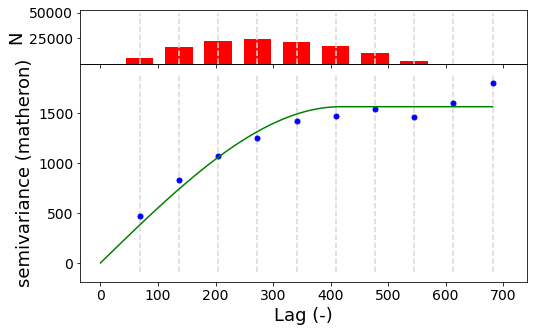

In [9]:
default = skg.Variogram(coordinates, values)
fig = default.plot()

fig.savefig('./figures/default_variogram.pdf', dpi=DPI)

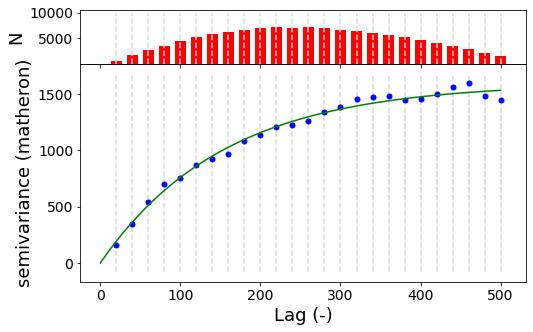

In [10]:
panvar = skg.Variogram(coordinates, values, maxlag=500, model='exponential', n_lags=25)
fig = panvar.plot()

fig.savefig('./figures/pancake_variogram.pdf', dpi=DPI)

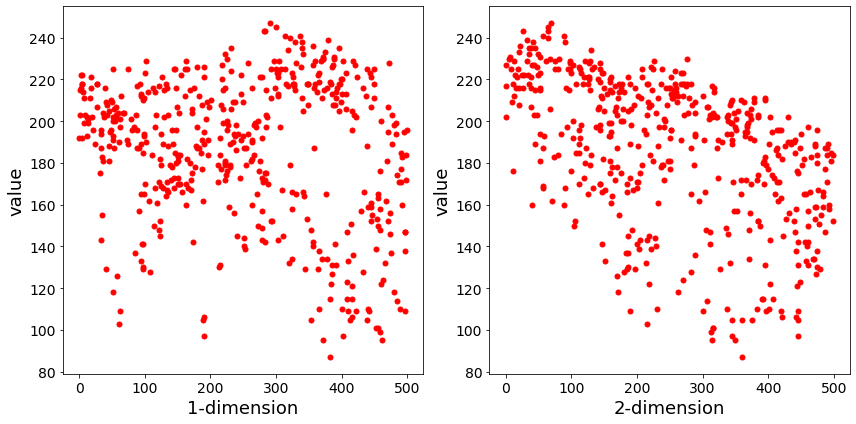

In [11]:
fig = panvar.location_trend()
fig.savefig('./figures/pancake_locationtrend.pdf', dpi=DPI)

## Kriging

In [12]:
# _ok = skg.OrdinaryKriging(panvar, min_points=5, max_points=15)

# xx,yy = np.mgrid[0:500:100j, 0:500:100j]

# t1 = time()
# field2 = _ok.transform(xx.flatten(), yy.flatten()).reshape(xx.shape)
# t2 = time()

# sigma = _ok.sigma.reshape(xx.shape)
# print(f'Kriging took {np.round(t2 - t1, 2)} seconds')

In [13]:
# fig, _a = plt.subplots(1, 3, figsize=(12,6))
# axes = _a.flatten()
# axes[0].matshow(band, vmin=50, vmax=250, cmap='Reds_r')
# axes[1].matshow(field2, vmin=50, vmax=250, cmap='Reds_r')
# axes[2].matshow(sigma, cmap='RdYlGn_r')

In [14]:
model = panvar.to_gstools()
print(model)
X, Y = zip(*panvar.coordinates)
cond_vals = panvar.values

Exponential(dim=2, var=1.6e+03, len_scale=4.64e+02, nugget=0.0, rescale=3.0)


In [15]:
ok = gs.krige.Ordinary(model, [X, Y], cond_vals)
x = y = range(0, 500, 1)
t1 = time()
field = ok.structured([x, y])
t2 = time()
print(f'Kriging took {np.round(t2 - t1, 2)} seconds')

Kriging took 65.45 seconds


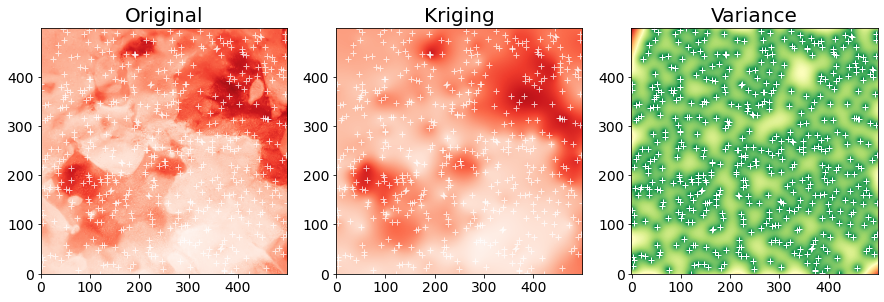

In [16]:
fig, _a = plt.subplots(1, 3, figsize=(15,5))
axes = _a.flatten()
axes[0].imshow(band.T, vmin=50, vmax=250, cmap='Reds_r', origin='lower')
axes[1].imshow(field[0].T, vmin=50, vmax=250, cmap='Reds_r', origin='lower')
axes[2].imshow(field[1].T, cmap='RdYlGn_r', origin='lower')
axes[0].set_title(f'Original')
axes[1].set_title(f'Kriging')
axes[2].set_title('Variance')
axes[0].plot(X, Y, 'w+', markersize=6, alpha=0.7)
axes[1].plot(X, Y, 'w+', markersize=6, alpha=0.7)
axes[2].plot(X, Y, 'w+', markersize=6)

fig.savefig('./figures/pancake_kriging.pdf', dpi=DPI)

In [17]:
print(f'Field  variance:   {np.var(band).round(1)}')
print(f'Result variance:   {np.var(field[0]).round(1)}')
print(f'Variance captured: {(np.var(field[0]) / np.var(band) * 100).round(1)}%')
print(f'Field  maxima:     {np.min(band)} - {np.max(band)}')
print(f'Result maxima:     {np.min(field[0]).round(0)} - {np.max(field[0]).round(0)}')
print(f'Observ.  maxima:   {np.min(values)} - {np.max(values)}')

Field  variance:   1249.5
Result variance:   1142.8
Variance captured: 91.5%
Field  maxima:     73 - 253
Result maxima:     87.0 - 247.0
Observ.  maxima:   87 - 247


## directional variogram

In [18]:
east = skg.DirectionalVariogram(aniso_c, aniso_v, azimuth=0, tolerance=45, maxlag=100, n_lags=15)
north = skg.DirectionalVariogram(aniso_c, aniso_v, azimuth=90, tolerance=45, maxlag=100, n_lags=15)

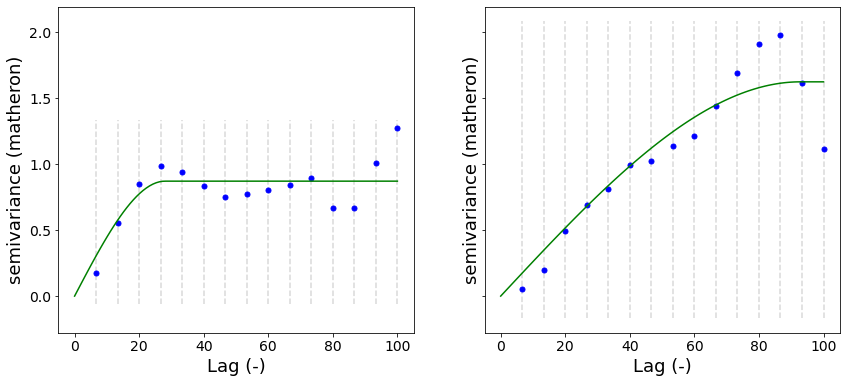

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

fig = east.plot(axes=axes[0], show=False, hist=False)
fig = north.plot(axes=axes[1], show=False, hist=False);
fig.show()

In [20]:
pan_east = skg.DirectionalVariogram(coordinates, values, azimuth=0, tolerance=45, maxlag=None, n_lags=25, model='stable')
pan_north = skg.DirectionalVariogram(coordinates, values, azimuth=90, tolerance=45, maxlag=None, n_lags=25, model='stable')

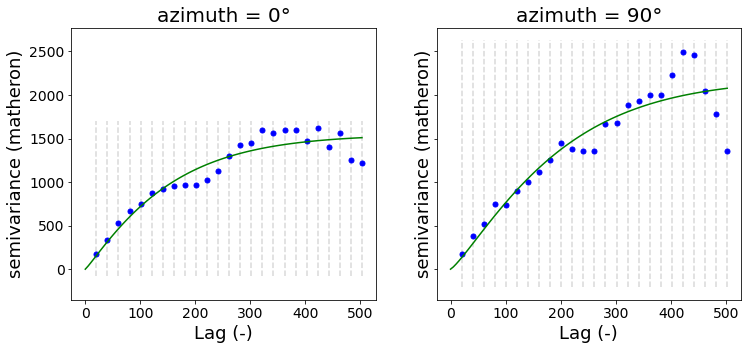

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

fig = pan_east.plot(axes=axes[0], show=False, hist=False)
fig = pan_north.plot(axes=axes[1], show=False, hist=False)
axes[0].set_title('azimuth = 0°')
axes[1].set_title('azimuth = 90°')
fig.savefig('./figures/pancake_anisotropic.pdf', dpi=DPI)

In [22]:
d = pd.DataFrame([pan_east.describe(flat=True), pan_north.describe(flat=True)]).T
d.columns = ['azimuth = 0°', 'azimuth = 90°']
d

azimuth = 0°   azimuth = 90°
model                               stable          stable
estimator                         matheron        matheron
dist_func                        euclidean       euclidean
normalized_effective_range   208469.987109   251640.999989
normalized_sill             2502746.656654  5463332.308484
normalized_nugget                        0               0
effective_range                 414.210211      501.638316
sill                           1547.738957     2186.299204
nugget                                   0               0
shape                             1.105512        1.204478
bin_func                              even            even
normalize                            False           False
fit_method                             trf             trf
fit_sigma                             None            None
use_nugget                           False           False
maxlag                                None            None
n_lags                                  25              25
verbose                              False           False

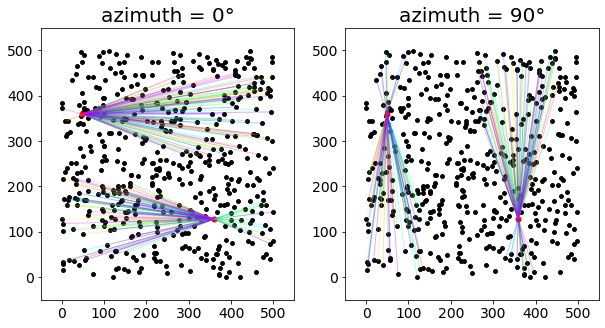

In [30]:
skg.plotting.backend('matplotlib')
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

fig = pan_east.pair_field(ax=axes[0], points=[42, 170])
fig = pan_north.pair_field(ax=axes[1], points=[42, 170])

axes[0].set_title('azimuth = 0°')
axes[1].set_title('azimuth = 90°')
fig.savefig('./figures/pancake_pair_field.pdf', dpi=DPI)

## Space-Time

In [15]:
STV = skg.SpaceTimeVariogram(coords, vals[:,::6], x_lags=20, t_lags=20, model='product-sum', maxlag=300)

In [19]:
STV.tbins

array([ 2.9,  5.8,  8.7, 11.6, 14.5, 17.4, 20.3, 23.2, 26.1, 29. , 31.9,
       34.8, 37.7, 40.6, 43.5, 46.4, 49.3, 52.2, 55.1, 58. ])

In [20]:
skg.plotting.backend('plotly')
fig = STV.contourf()
fig.update_layout(
    xaxis_title='space',
    yaxis_title='time',
    font=dict(size=14)
)

fig.write_image('./figures/stv_contour.pdf')
fig.show()

In [35]:
skg.plotting.backend('plotly')
fig = STV.plot()
fig.update_layout(
    template='plotly_white',
#    margin=dict(l=25, r=25),
    scene=dict(camera=dict(
        eye=dict(x=-0.8979861027745052, y=-1.8543628019442224, z=0.07042412931253939),
        center=dict(x=0, y=0, z=0),
    )),
    width=600,
    height=600
)
fig.show()
fig.write_image('./figures/st_3dplot.pdf')

## Distance-weighted fit

In [10]:
cm = plt.get_cmap('gist_earth')
y = [1,7,9,6,14,10,13,9,11,12,14,12,15,13]
x = list(range(len(y)))

xi = np.linspace(0, len(y), 100)

# increase distance by 1 to avoid zeros
X = np.asarray([(_ + 0.) for _ in x])

s1 = X / np.max(X)
s2 = np.exp((s1 + 1)**2)
s3 = np.sqrt(s1)
s4 = np.power(s1, 2)
s = (s1, s2, s3, s4)
labels = ('linear', 'exp', 'sqrt', 'sq')


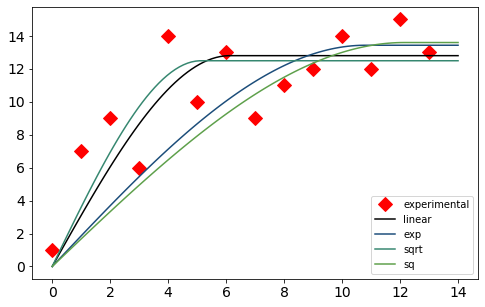

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(8,5))
ax.plot(x, y, 'rD', label='experimental')
cofs = list()
for i in range(4):
    cof, cov = curve_fit(skg.models.spherical, x[:], y[:], sigma=1/s[i][:], p0=(8.,14.), bounds=(0,(14,14)))
    cofs.append(cof)
    yi = list(map(lambda x: skg.models.spherical(x, *cof), xi))
    ax.plot(xi, yi, linestyle='-', color=cm((i/6)), label=labels[i])
plt.legend(loc='lower right')
cofs
fig.savefig('./figures/distance_fit.pdf', dpi=DPI)

In [12]:
models = []
for cof in cofs:
    model = gs.Spherical(dim=2, var=cof[1], len_scale=cof[0])
    models.append(model)

In [13]:
xx = yy = range(100)
srfs = []
fields = []

for model in models:
    srf = gs.SRF(model, seed=13062018)
    fields.append(srf.structured((xx, yy)))
    srfs.append(srf)

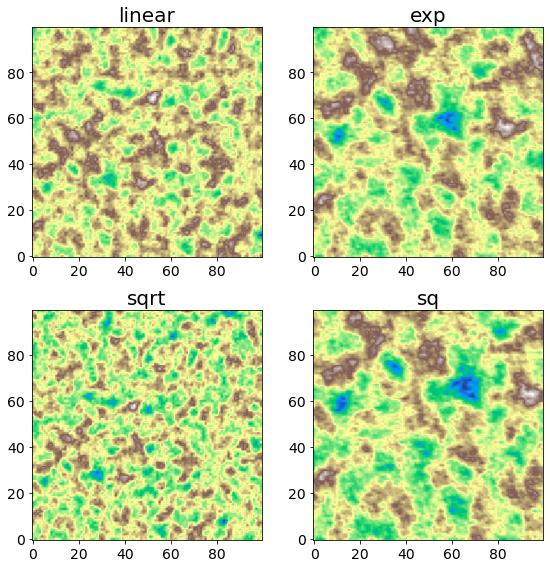

In [185]:
fig, _a = plt.subplots(2, 2, figsize=(8, 8))
axes = _a.flatten()

for i, ax in enumerate(axes):
    ax.imshow(fields[i], origin='lower', cmap='terrain_r')
    ax.set_title(labels[i])
plt.tight_layout()
fig.savefig('./figures/dist_fit_fields.pdf', dpi=DPI)